# SESSION 2: CONVOLUTIONAL NEURAL NETWORKS

SO Basics of Neural Networks 2023 school at the IAA-CSIC. Nov 2023.  
Eduardo Sánchez Karhunen  (fesanchez@us.es)  
University of Seville. Spain.  Dept. of CS and Artificial Inteligence

### 1. Introduction

In the previous session we tackled the fashion-MNIST classification problem using a simple MLP architecture. Its concrete structure was:

* An input flattening layer with 28x28=784 neurons.
* Two hidden layers with 300 and 100 neurons, respectively.
* A final output layer with 10 neurons.

After the network training, a 89% accuracy was reached.

<br>

| Tamaño imagen  | # parámetros modelo  | Validation accuracy |
| :-----: | :------------------: | :-----------------: |
| 28 x 28 |     $≃$ 270K         |        89%          |

<br>

Images with a 28x28 shape are pretty small. If each image dimension were inceased by x10, a 280x280 image were obtained. This change has a huge impact:

* Now, the flattened input array would have 280 x 280 = 78.400 neurons.
* The hidden layer also should be increased up to, perhaps, 1K neurons.
* Then, the number of parameters associated to this layer could be 78k x 1K neurons = 78 million of neurons.

Obviously, seeking solutions in a 78M-dimension space does not seem to be the best strategy to solve image problems.

As we have seen in this session, different authors have imposed constraints into the network architecture, based on previous knowledge about the problem to be solved. Following this idea, a new architecture was proposed: __Convolutional Neural Networks__. This implied 2 new types of layers: convolutional and pooling layers.

In this notebook we will learn how convolutional neuronal networks are defined and trained using TensorFlow.

### 2. Loading data

In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

For reproducibility purposes, a seed if provided to the system.

In [16]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

The Fashion-MNIST train and test datasets are obtained using the Tensorflow dataset library:

In [17]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

As we know, each image has shape 28x28:

In [18]:
print("training dataset: ", X_train.shape)
print("test dataset: ", X_test.shape)

training dataset:  (60000, 28, 28)
test dataset:  (10000, 28, 28)


Pixel in these images take values in the range 0-255. Remember that normalization is needed when gradient descent is used to solve an optimization problem.

In [19]:
X_train = X_train/255.0
X_test = X_test/255.0

We also need the name of each class and its numerical conversion. It can be obtained from:

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

![picture](https://drive.google.com/uc?id=1r8wAnDCzXpPczJo5_bckYxXvgVPAOHHa)

This info is collected in a list:

In [20]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 3. Dataset visualization

A basic step in any image problem should be the dataset visualization. One of the the easiest ways is using the matplotlib library. In this case some samples are shown:

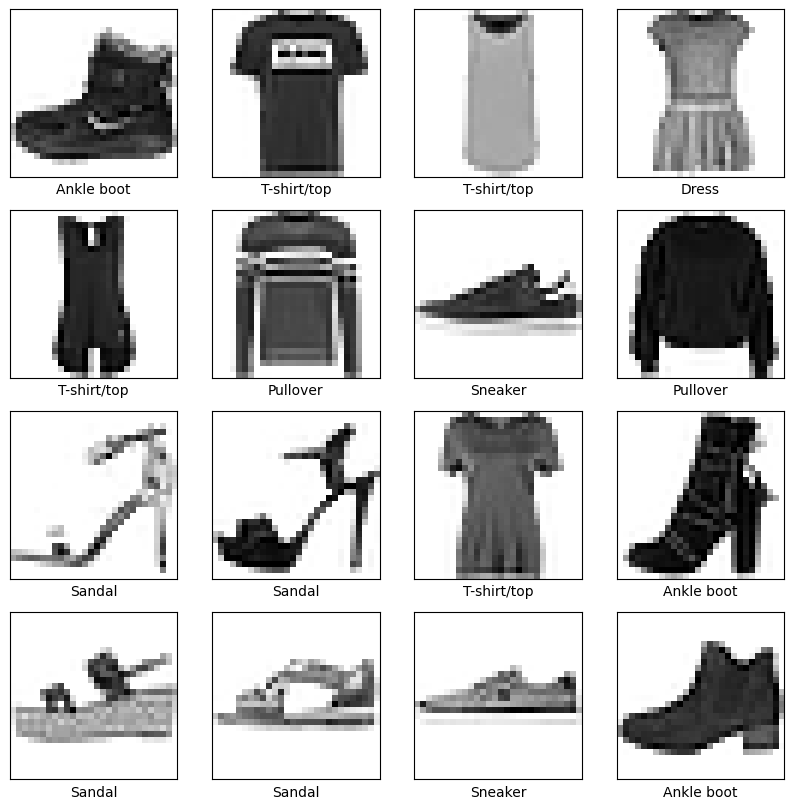

In [21]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])                         # remove x ticks
    plt.yticks([])                         # remove y ticks
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])    # add image label

We can make a zoom and plot any of these images with more detail:

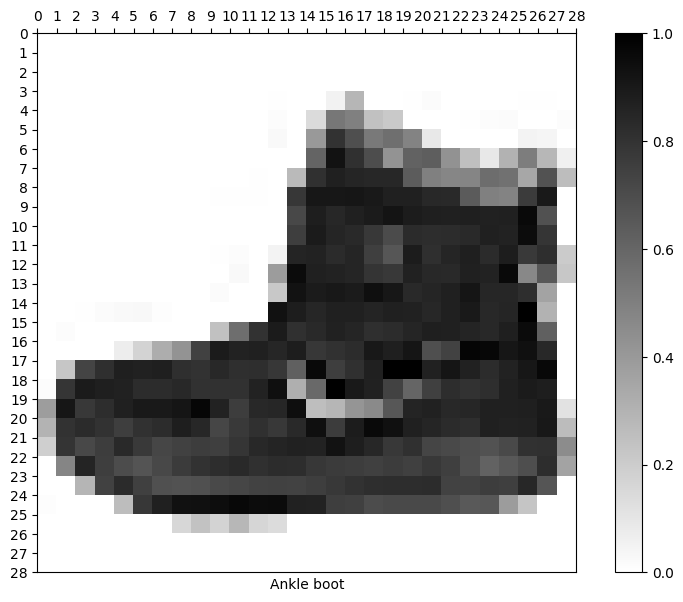

In [22]:
index = 0
_, ax = plt.subplots(figsize=(10,7))
plt.imshow(X_train[index], cmap=plt.cm.binary)
plt.xlabel(class_names[y_train[index]])
plt.colorbar()

ticks_pos = np.arange(-.5, 28, 1)
ticks_labs = np.arange(0, 29, 1)

ax.set_xticks(ticks_pos)
ax.set_yticks(ticks_pos)
ax.set_xticklabels(ticks_labs)
ax.set_yticklabels(ticks_labs)
ax.xaxis.tick_top()

To make clearer the relationship between images and arrays, we can overlap the numerical values of the matrix and its graphical representation:

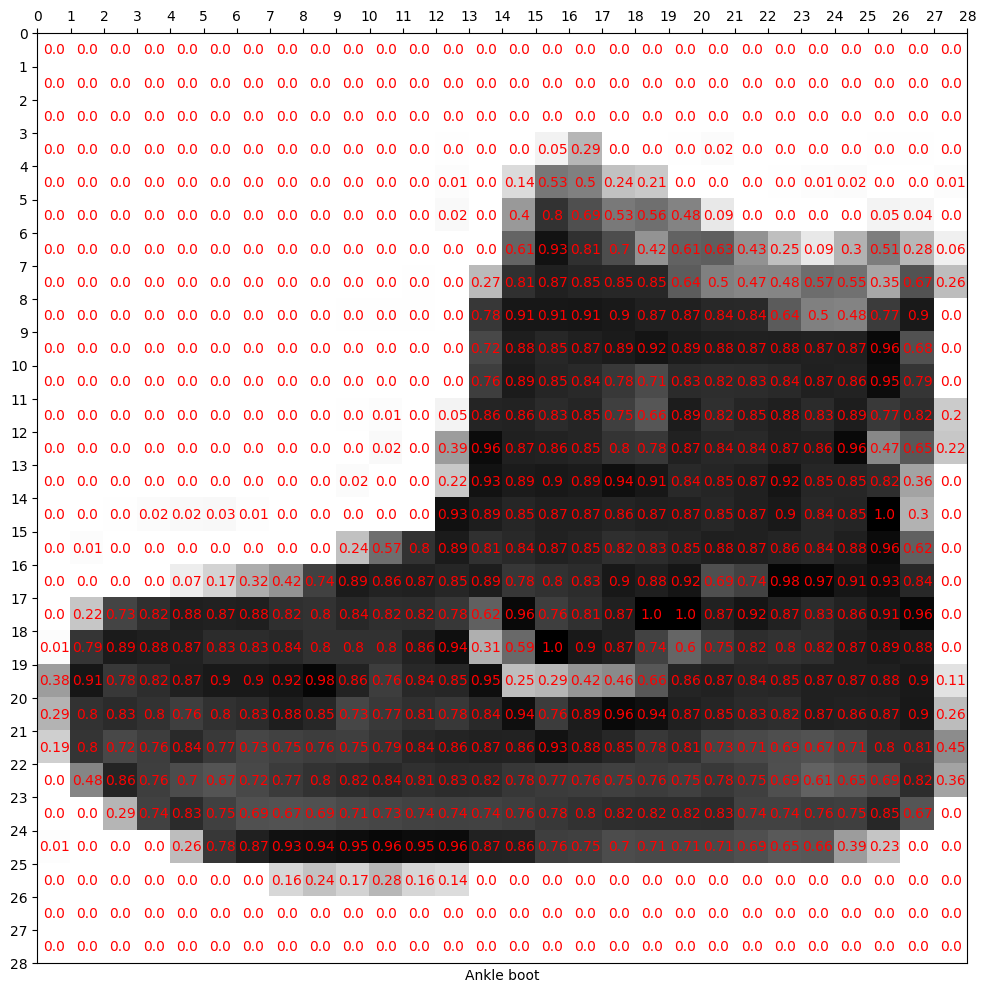

In [23]:
index = 0
_, ax = plt.subplots(figsize=(12,13))
plt.imshow(X_train[index], cmap=plt.cm.binary)
plt.xlabel(class_names[y_train[index]])

ticks_pos = np.arange(-.5, 28, 1)
ticks_labs = np.arange(0, 29, 1)

ax.set_xticks(ticks_pos)
ax.set_yticks(ticks_pos)
ax.set_xticklabels(ticks_labs)
ax.set_yticklabels(ticks_labs)
ax.xaxis.tick_top()

for i in range(28):
    for j in range(28):
        text = ax.text(j, i, round(X_train[index][i, j], 2), ha="center", va="center", color="red")

### 4. Model architecture

For learning purposes, we will implement the simplest CNN (Convolutional Neural Network) to tackle this classification problem. This network will be composed by:
* A preprocessing stage with:
  > - A convolutional layer  
  > - A pooling layer  
* A decision layer composed by:
  > - A dense layer   
  > - A output layer  

Typically, real models concatenate multiple pairs of convolutional & pooling layers.

<br>
<br>

![picture](https://drive.google.com/uc?id=1vDe4gbSnzEMxFUqwIq5eXP9Mgh-sZaGn)




### 4.1. Convolutional layer & Input layer

Remember that NNs always have a first layer acting as a host or entry-point to the network. In CNNs this function is performed by the first Convolutional Layer. In some sense, it receives image input samples and provides them to the rest of the network "informing" the following layers about the input image shape.

A convolutional layer has multiple parameters:
* __filters__: it is the number of kernels. Each kernel goal is to extract a feature from the image.
* __kernel_size__: it is the shape of the kernel. Typical shapes are: 3x3, 5x5 or 7x7.
* __strides__: it represents how many steps (pixels) the kernel is shifted along the image to perform the convolution. In fact, this parameter is a tuple (stride_h, stride_v) because we could consider different vertical and horizontal strides.
* __padding__: a decision must be taken about how to act when image borders are reached during the convolution operations.
> If padding = yes, the image borders are padded with zeros.  
> If padding = No, then no padding is added.  
* Finally, as any other layer, we need an __activation function__. Remember that s-shapes functions are avoided. They are substituted by functions of the ReLU family.

More details can be obtained in (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).



In [24]:
conv_1 = tf.keras.layers.Conv2D(filters=12,               # number of filters (number of kernels)
                                kernel_size=(3, 3),       # kernel shape
                                strides=(1, 1),           # how shift kernel moving along the image
                                padding='valid',          # either to include padding or not
                                activation='relu',        # activation function
                                name='conv_1',
                                input_shape=(28, 28, 1))

Once our images are processed by this layer, their shape is altered:

* The number of channels of the transformed image = number of kernels. The "new image" has a channel built by each applied kernel (one channel for each extracted feature).

* The resulting dimensions depend on either padding is applied or not:
> * __Padding = yes__: dimensions are not altered.  
> * __Padding = no__: each dimension suffers a pixels reduction. This reduction amount is (kernel_size - 1).

In this concrete layer, we have selected padding = No, then the output shape is: (28-2, 28-2, 12) = (26,26,12).

<br>

![picture](https://drive.google.com/uc?id=1PNscVkRyvI6umnSMdXb7FZLmcoewEkwB)


### 4.2. Pooling layer

This layer performs a subsampling of each of the features (each of the channels) received from the previous layer.

It has two main parameters:
* __pool_size__: the image is divided into rectangles of this shape. After that, the maximum pixel value of the rectangle is selected.
* __strides__: typically this rectangle is shifted the same size of the pool. As a consequence, there is no overlapping between them. But if necessary, we could obtained overlapping rectangles.

In [25]:
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                      strides=(2, 2),
                                      name='pool_1')

After the pooling transformation the resulting "image" can be easily calculated dividing the image shape by the pool_size.

In our case, the output shape will be: (26/2, 26/2, 12) = (13, 13, 12)

<br>

![picture](https://drive.google.com/uc?id=1NR_9TTD7XSnDAFOBLiXW2QWHr4tK18Iv)

### 4.3. MLP or "Decision layer"

After the signal preprocessing, we have transformed the input image to extract features and take a decision about its class. Always, this decision is taken by a group of dense layers. Hence, the final stage of the CNN is always a MLP (typically with 3-4 layer).

Remember that this stage only accepts 1D-arrays. Hence the 2D-arrays managed by the previous convolutional stage must be flattened.

Then, this MLP needs the following layers:

* A flatten layer. To make a transition between the preprocessing stage (2D-world) and the decision stage (1D-world).

* 1-2 dense layers. These layers facilitates the transformations between the huge flattened array and the 10-output classes.  

* An output layer. To take the final decision.

First of all, we define our flatten layer:

In [26]:
flatten_layer = tf.keras.layers.Flatten()

Once the flattened layer has completed its operation, the image has been transformed into a 1D-array of size: 13x13x12 = 2028.

After that, a dense layer is defined to reduce the dimensionality of the information from 2028 to 128.

In [27]:
dense_1 = tf.keras.layers.Dense(units=128, activation='relu', name='dense_1')

Finally, a 10-neuron layer is defined. As always,

* Output layer neurons = number of classes.
* Output layer activation function:
> * 2 classes: sigmoid  
> * (>2) classes: softmax

In [28]:
output_layer = tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer')

All the previously created layers are stacked into a "list" of layers using the Sequential API.

In [29]:
model = tf.keras.Sequential()

model.add(conv_1)
# output shape: (26,26,12)

model.add(pool_1)
# output shape: (13,13,12)

model.add(flatten_layer)
# output shape: 2028

model.add(dense_1)
# output shape: 128

model.add(output_layer)

#### 5. Parameters of the model



A description of the model can be obtained using `summary`. It shows the type, dimensionality and #params of each layer.

The input layer has no parameters, while the rest of layers have:

*   conv_2d: (3 x 3) x 12 + 12 = 120  (kernel_size_v x kernel_size_h x #channels) + kernels

*   max_pooling: No parameters.

*   flatten: No parameters

*   dense: 2028 x 128 = 259584 + 128 = 259712
*   output_layer = 128 x 10 + 10 = 1290

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 pool_1 (MaxPooling2D)       (None, 13, 13, 12)        0         
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               259712    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 261122 (1020.01 KB)
Trainable params: 261122 (1020.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 6. Functional API: alternative model definition

There are two main ways of defining a NN:
* A sequential API. Its the way we have used up to this point.
* A functional API. It is an alternative way of defining networks. It is much more flexible and is needed in some situations. Instead of creating a list of layers, layers are called as functions.

We can define our network using this functional API.

* First of all, we define an explicit Input layer indicating the shape of the input image.
* Surprisingly, the previously defined layers can be called as functions.
* Finally, instead of a `Sequential` list of layers, a `Model` is created. This model receives two arguments: inputs and outputs.  

In [36]:
inputs = tf.keras.Input(shape=(28, 28, 1), name='input_layer')

x = conv_1(inputs)
x = pool_1(x)
x = flatten_layer(x)
x = dense_1(x)
outputs = output_layer(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

It can be checked easily that both models: defined via Sequential and via Model are equivalent and have the same number of parameters.

In [32]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 pool_1 (MaxPooling2D)       (None, 13, 13, 12)        0         
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               259712    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 261122 (1020.01 KB)
Trainable params: 261122 (1

### 7. Model training

As in any other NN problem we must indicate:
* A loss function to be optimized.
* An optimization "technique".

In the previous MLP notebook we defined these parameters as strings.
```
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
```
In this ocassion, we will show an alternative way of defining them, via classes.


In [33]:
loss_function = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=loss_function,
    optimizer=optim,
    metrics=['accuracy'])

From the summary, we can notice that convolutional models expects that each input image is a tensor with the following structure:

(dim_1, dim_2, num_canales)

In our case, there is only one channel (grayscale). Then, its associated shape should be (28, 28, 1). But out dataset images are arrays with shape:  (28, 28).

In [37]:
X_train[0].shape

(28, 28)

Hence, we must add artifitially an extra dimension indicating that our grayscale images can be interpreted as 1 channel images.

In [38]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

Now we can train the model with parameters:
* Between 7 and 10 epochs are enough to train.
* 20% is selected for validation.`

In [39]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    validation_split=0.2)

Epoch 1/8
1500/1500 [==============================] - 15s 3ms/step - loss: 0.4432 - accuracy: 0.8419 - val_loss: 0.3487 - val_accuracy: 0.8773
Epoch 2/8
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3079 - accuracy: 0.8901 - val_loss: 0.3005 - val_accuracy: 0.8928
Epoch 3/8
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2606 - accuracy: 0.9053 - val_loss: 0.2729 - val_accuracy: 0.9020
Epoch 4/8
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2283 - accuracy: 0.9150 - val_loss: 0.2643 - val_accuracy: 0.9022
Epoch 5/8
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2044 - accuracy: 0.9252 - val_loss: 0.2577 - val_accuracy: 0.9072
Epoch 6/8
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1779 - accuracy: 0.9344 - val_loss: 0.2607 - val_accuracy: 0.9078
Epoch 7/8
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1606 - accuracy: 0.9411 - val_loss: 0.2601 - val_accuracy: 0.909

As always the training history is plotted:

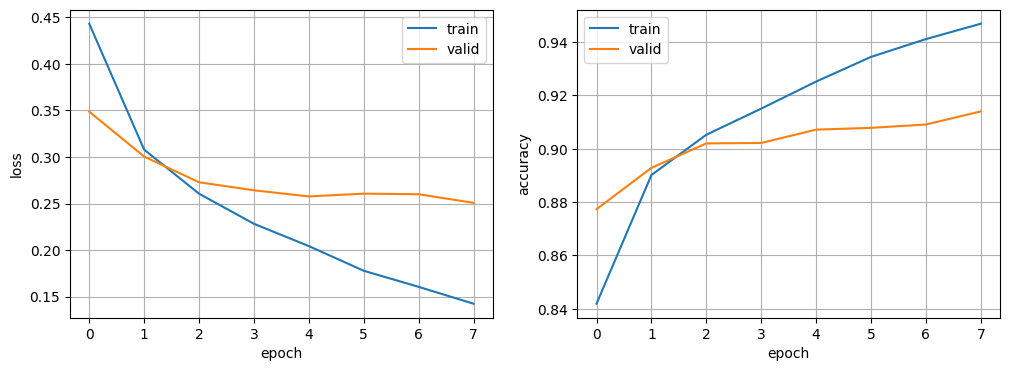

In [40]:
df_1 = pd.DataFrame({'loss_train': history.history['loss'],
                     'loss_valid': history.history['val_loss']
                    })

df_2 = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'accuracy_valid': history.history['val_accuracy']
                   })

data = [df_1, df_2]
y_labels = ['loss', 'accuracy']

f, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
for ax, y_label, df in zip(axs, y_labels, data):
    ax.plot(df, label=['train','valid'])
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(y_label)
    ax.legend();

In these plot we can observe an undesired behaviour that will be explained and tackled in the next session.

### 7. Model predictions

To obtain the model performance, comparing the prediction for $X\_test$ with $y\_test$ using `evaluate`:

In [41]:
res = model.evaluate(X_test,y_test, verbose=0)
print(f"model accuracy: {np.round(res[1],2)}")

model accuracy: 0.91


Given an input image, the model output can be obtained using the `predict` method. It corresponds to the output of the last layer that is interpreted as  the probability of the image to correspon to each of the ten classes.

In [42]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 98ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

The predicted class associated to the image is obtained as the class with the higher probability:

In [43]:
y_predicted = np.argmax(y_proba.round(2), axis=1)
y_predicted

array([9, 2, 1])

In [44]:
y_test[:3]

array([9, 2, 1], dtype=uint8)

### 8. Conclusion

Hence, using a convolutional architecture with 12 kernels we have improved 5% the MLP results.

<br>

| Architecture| Image size  | # number of parameters  | Valid accuracy | Test accuracy |
|:-- |:-----: | :------------------: | :-----------------: | :-: |
| MLP|28 x 28 |     $≃$ 270K         |        88-89%          | 86% |
| Conv|28 x 28 |     $≃$ 260K         |        90-91%          | 91% |

<br>

In more realistic situations if we increase the image size:

* As we have seen, in MLPs the number of parameters explodes, making very difficult their training.
* On the contrary, in CNNs we can adapt our CNN architecture chaining as many convolutional + pooling stages as needed.